# Controle de velocidade Fuzzy

Bibliotecas que serão usadas: <br>
    Simpful - 2.5.0 -> https://github.com/aresio/simpful <br>
    Numpy - 1.18.5 -> https://numpy.org/ <br>
    Scipy - 1.5.0 -> https://www.scipy.org/ <br>
    Control - 0.9.0 -> https://github.com/python-control/python-control

## Importando as bibliotecas

In [1]:
#Importando as bibliotecas
import simpful as sf
import numpy as np
import control as ctl
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate
import scipy.signal as sig
from scipy.signal import lti,step2,cont2discrete
from scipy.optimize import minimize
#%matplotlib

### Criando o modelo da bicicleta elétrica

As equações seguintes modelam o seguinte diagrama de corpo livre de uma bicicleta elétrica:

$ \begin{bmatrix} \dot{\omega} \\ \dot{I} \end{bmatrix} = \begin{bmatrix} \frac{1}{(J + M.r²)}.(k_{t}.I_{a} + T_{humano} - B.\omega - r.(F_{rr} + F_{a} + F_{w}) - T_{f}\\ \frac{1}{L_{a}}.(V_{a} - K_{t}.\omega - R_{a}.I_{a}) \end{bmatrix}$

Com

$v = \omega.r$

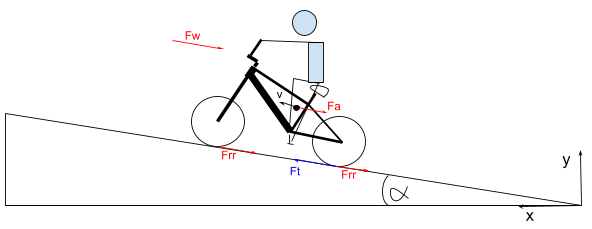

Figura 1 - Diagrama de corpo livre de uma bicicleta

##### Determinando Ra e La

In [2]:
#Ra - para Torque = 0 tem-se do datasheet: Pout = 0,3171 W e Ia = 1,3528
pout = 0.3171
ia = 1.3528
Ra = pout/(ia**2)
print('Resistência da armadura é',Ra,"ohms")


#La - resolvendo o Sistema de equações de EDO para entre o intervalo do datasheet = [8,8.7572] sem estar conectado a carga
def corrente(x,t,la,Th):
    kt = 1.49
    u = 36
    ra = 0.1733
    j = 0.222
    B = 1e-3
    Tf = 1.71
    dxdt = [1/(j)*(kt*x[1] - B*x[0] - Tf - Th), 1/la*(u - kt*x[0] - ra*x[1])]
    
    return dxdt
    
#t = np.arange(7,12,0.8)
t = [8,8.7572]#intervalo de tempo
Ia = 7.8029
la = 0.001
erro = 0.5
I0 = [234.8*0.105,6.2679]#Condições no tempo inicial
Th = 10 #  torque no tempo final
while erro >= 0.1:    
    y = odeint(corrente,I0,t,args=(la,Th))
    Iaa = y[1]
    erro = abs(Iaa[-1] - Ia)/Ia
    la = la + 0.001
    
print('o valor da indutância da armadura é', la, 'H')

Resistência da armadura é 0.17327226514182117 ohms
o valor da indutância da armadura é 0.002 H


In [3]:
def bicicleta_eletrica(x,t,u,tr):
    #ENTRADAS
        #t - tempo [s]
        #u - tensão [V]
        #tr - Inclinação [graus] 
        
    #ESTADOS
    w = x[0] #velocidade angular do motor/roda [rad/s]
    Ia = x[1] #corrente na armadura [A]
    
    #PARÂMETROS
    r = 0.25 #raio da roda bicicleta [m]
    M = 107 #massa do conjunto bicicleta elétrica ciclista [kg]
    n = 60 #cadência no pedal[rpm]
    kt = 1.49 #constante de torque do motor [N.m/A]
    Tf = 1.71 #torque viscoso resistivo do motor[N.m]
    i = 0.5 #relação de transmissão

    As = 0.509#Area frontal do ciclista [m²]
    Crr = 0.0025 #Coeficiente de atrito de rolagem 
    Cw = 0.76#Coeficiente de arrasto do ar
    rho = 1.2#densidade do ar [kg/m³]
    g = 9.81 #gravidade [m/s²]
    
    ra = 0.1733 #resistência da armadura do motor[ohms]
    La = 2e-3 # indutância da armadura do motor [H] 
    jl = 0.0625 #inercia da carga - roda da bicicleta roda de 1kg com raio de 0,25m
    jm = 7.35e-3 #inercia do motor 
    jt = jl+jm #inercia total
    B = 1e-3#coeficiente de atrito viscoso no motor
    
    #EQUAÇÕES DIFERENCIAIS DO MODELO
    thetai = np.radians(45)# ângulo inicial do pedivela

    #Torque humano - Dependente do tempo
    Th = 12 #Torque médio no tempo entre 1 e 50

    #Th = ((30*i*r)/(np.pi*n*0.165))*(85 + 65/(t**0.025))*np.sin(thetai + 2*np.pi*n/60*t)
    #Th = 12

    # w = velocidade angular 
    #tr = ângulo de inclinação do trajeto

    # Força de atrito do ar [N] - 
    fw = 0.5*As*Cw*rho*r**2*w**2 #fw = 0.4477*(r*3.6)*y[0] - 1.7909 /linearizada e para velocidade angular => v = w*r*3,6 em km/h

    # Força de atrito de rolamento [N]
    frr = Crr*M*g*np.cos(tr)

    # Força gravitacional [N]
    fa = M*g*np.sin(tr)
    
    #Motor elétrico
    dxdt = [1/(jt+M*r**2)*(kt*Ia - B*w - r*(fw + frr + fa) +  Th - Tf), 1/La*(u - kt*w - ra*Ia)]
    
    return dxdt


def trajeto(g): 
    return np.radians(g)

##### Definindo as métricas no tempo

In [4]:
def metricasTempoControle(w2,t,e,sp):
    #Retorna uma tupla contento os valores de overshoot, tempo de subida, tempo de pico, tempo de acomodação e erro de regime.
    
    #Overshoot
    os = (np.amax(w2)-sp[0])/sp[0]*100
    print('O valor do overshoot é de ', os, '%')
    
    #Tempo de subida
    wf = w2[-1] #resposta final
    wa = 0.1*wf
    wb = 0.9*wf
    pa = np.where(w2<=wa)
    pb = np.where(w2>=wb)
    ta = t[pa]
    tb = t[pb]
    ts = tb[0] - ta[-1]
    print('O valor do tempo de subida é ', ts, 's')
    
    #Tempo de pico
    tp = t[np.argmax(w2)]
    print('O valor do tempo de pico é ', tp, 's')

    #Tempo de acomodação
    if e[0]>1:
        er = e/sp[0]
    else:
        er = e
    pep2 = np.where(abs(er)<=0.02)[0]
    tp2 = t[pep2]
    pos = []
    for j in range(len(pep2)-1):
        if pep2[j+1]-pep2[j] <= 1:
            pos.append(pep2[j])
        else:
            pos = []
    ta = tp2[pos[0]]
    print('O valor do tempo de acomodação é ', ta, 's')

    #erro
    err = e[-1]/sp[0]*100
    print('O valor do erro de regime é ', err,'%')
    
    return os, ts, tp, ta, err

## Sistema de controle Fuzzy

##### Definindo as condições iniciais

In [5]:
#Tempo
t = np.linspace(1,50,350)

#trajetos
g = np.linspace(0,8,350)#np.linspace(0,8,350)#np.linspace(3,8,350)#np.ones(350)*2
#tr = np.concatenate((np.ones(50)*np.radians(1),np.ones(50)*np.radians(-2),np.linspace(0,8,250)), axis=0)

#Condições inicias do sistema 
w = np.zeros(len(t)) #velocidade angular inicial [rad/s]
I1 = np.zeros(len(t)) #corrente na armadura inicial [A]
x0 = [0.0,0.0] #Vetor com as condições iniciais para velocidade angular e corrente
tr = trajeto(g) #[rad]
u = np.ones(len(t))*0 #Tensão inicial [V]
#ac = np.zeros(len(t)) # Aceleração angular inicial

#Armazenando resultados
sc = np.zeros(len(t))  # saída do controlador
vp = np.zeros(len(t))  # variável do processo
e = np.zeros(len(t))   # erro
ei = np.zeros(len(t))  # erro integral
dvp = np.zeros(len(t)) # derivada de vp

#Para o controle PID
P = np.zeros(len(t))   # proporcional
I = np.zeros(len(t))   # integral
D = np.zeros(len(t))   # derivativo

#Referência
sp = np.zeros(len(t))  # set point
vr1 = 12 # velocidade de refêrencia em km/h
vr2 = 12
vr3 = 12
#Vetor referência em velocidade angular - rad/s 
sp[0:80] = (vr1/3.6)/0.25 
sp[80:150] = (vr2/3.6)/0.25
sp[150:] = (vr3/3.6)/0.25
#wr = (vr1/3.6)/0.25 #para usar par entrada rampa
#sp = np.linspace(0.1,wr,len(t))#Entrada rampa

#Limites do controlador -> Caso de saturação
sc_up = 44 #tensão máxima de entrada
sc_down = 0 #Tensão mínima de entrada-> Desligado| Caso seja usado freio regenerativo sc_down será negativo

#Valor atual de vp - será w (velocidade angular)
vp[0] = w[0]

##### Criando o controlador Fuzzy

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.0 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



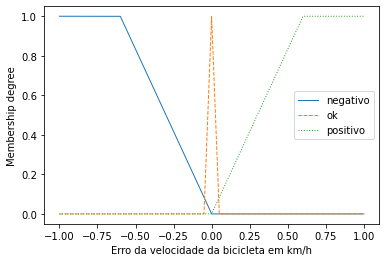

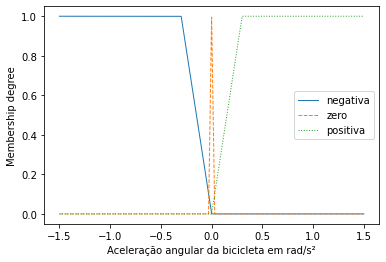

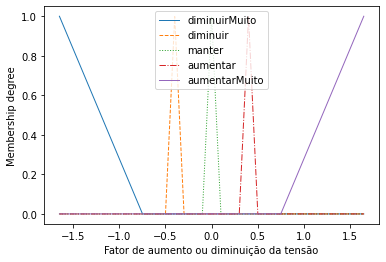

In [6]:
FS = sf.simpful.FuzzySystem() #Sistema de controle para o motor. Ele irá ajustar o valor da tensão no motor

# Variáveis linguísticas e funções de pertinência

## Erro da velocidade -> Representa o erro entre a velocidade de refêrencia e a velocidade real
E1 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Trapezoidal_MF(a=-1, b=-1, c=-0.6, d=-0.0),term = "negativo")
E2 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=-0.05, b=0, c=0.05),term = "ok")
E3 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Trapezoidal_MF(a=0.0, b=0.6, c=1, d=1),term = "positivo")
FS.add_linguistic_variable("ErroVelocidade", sf.simpful.LinguisticVariable([E1, E2, E3], concept="Erro da velocidade da bicicleta em km/h", universe_of_discourse=[-1,1]))

### Vizualizando o subgrupo velocidade
FS.plot_variable("ErroVelocidade")

## Aceleração -> Representa a aceleração  angular do conjunto bicicleta e ciclista
A1 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=-0.3, b=-0.3, c=-0.0),term = "negativa")
A2 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=-0.03, b=0, c=0.03),term = "zero")
A3 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=0.0, b=0.3, c=0.3),term = "positiva")

FS.add_linguistic_variable("Aceleracao", sf.simpful.LinguisticVariable([A1, A2, A3], concept="Aceleração angular da bicicleta em rad/s²", universe_of_discourse=[-1.5,1.5]))

### Vizualizando o subgrupo velocidade
FS.plot_variable("Aceleracao")

# Variáveis de saída
Te1 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=-1.65, b=-1.65, c=-0.75),term = "diminuirMuito")
Te2 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=-0.5, b=-0.4, c=-0.3),term = "diminuir")
Te3 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=-0.1, b=0, c=0.1),term = "manter")
Te4 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=0.3, b=0.4, c=0.5),term = "aumentar")
Te5 = sf.fuzzy_sets.FuzzySet(function=sf.fuzzy_sets.Triangular_MF(a=0.75, b=1.65, c=1.65),term = "aumentarMuito")

FS.add_linguistic_variable("Variacao_Tensao", sf.simpful.LinguisticVariable([Te1, Te2, Te3, Te4, Te5], concept="Fator de aumento ou diminuição da tensão", universe_of_discourse=[-1.65,1.65]))


### Vizualizando o subgrupo tensão
FS.plot_variable("Variacao_Tensao")

R1 = "IF (ErroVelocidade IS positivo) THEN (Variacao_Tensao IS aumentarMuito)"
R2 = "IF (ErroVelocidade IS negativo) THEN (Variacao_Tensao IS diminuirMuito)"
R3 = "IF (ErroVelocidade IS ok) THEN (Variacao_Tensao IS manter)"
R4 = "IF (ErroVelocidade IS ok) AND (Aceleracao IS negativa) THEN (Variacao_Tensao IS aumentar)"
R5 = "IF (ErroVelocidade IS ok) AND (Aceleracao IS positiva) THEN (Variacao_Tensao IS diminuir)"

FS.add_rules([R1, R2, R3, R4, R5])

#Definindo o controlador
def fuzzyControl(er, ace):
    #er = erro da velocidade [%]
    #ace = aceleração angular [rad/s²]
    FS.set_variable("ErroVelocidade", er)
    FS.set_variable("Aceleracao", ace)
    
    #Realizando o processo de inferência e de defuzzificação
    v = FS.Mamdani_inference(["Variacao_Tensao"])
    tensao = v['Variacao_Tensao']
    
    return tensao

O sistema de controle terá o seguinte diagrama de blocos:

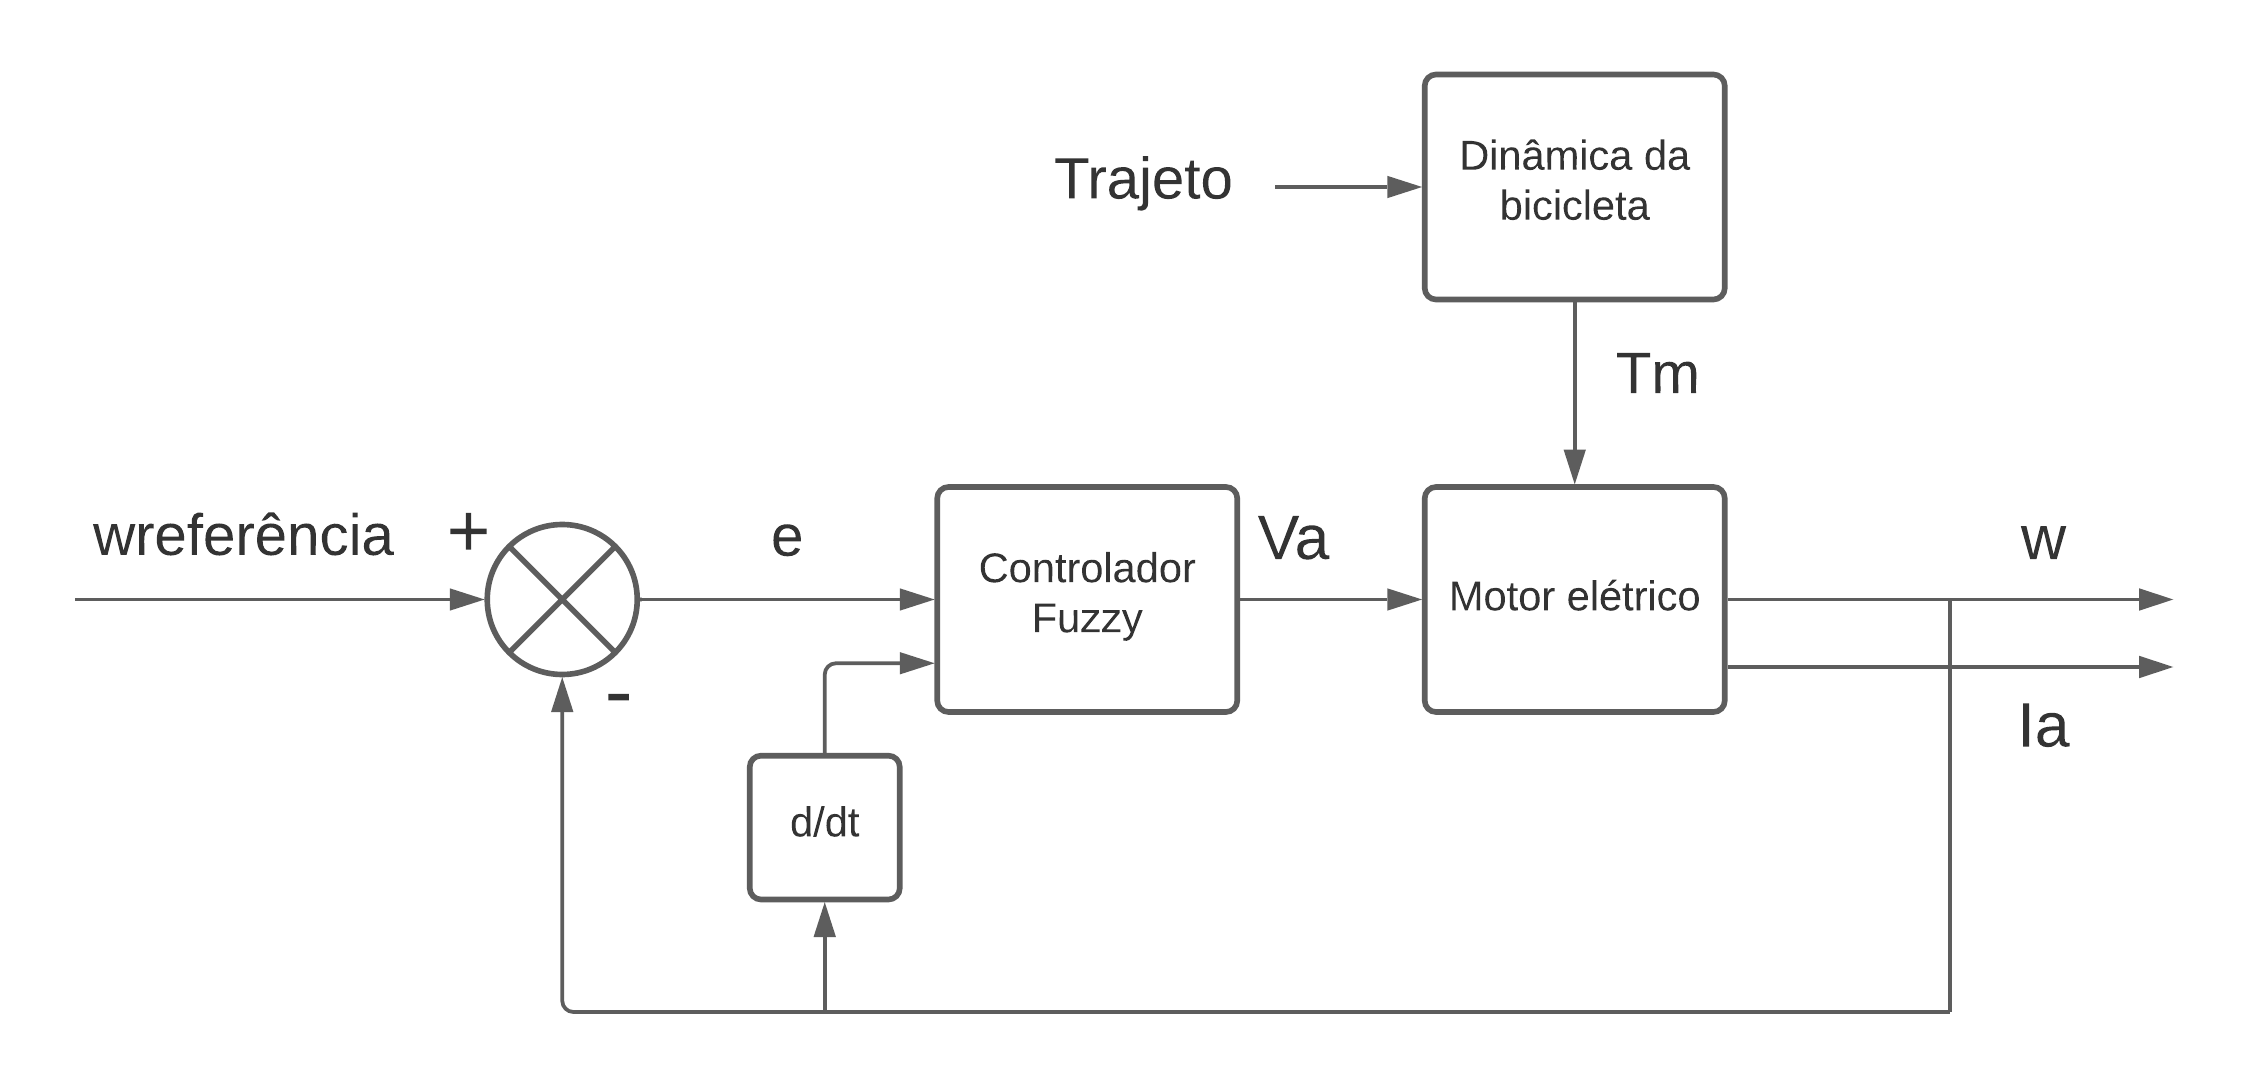

Figura 2 - Diagrama de blocos do sistema de controle fuzzy

###### Simulação fuzzy

In [7]:
for i in range(len(t)-1):    
    delta_t = t[i+1]-t[i]#passo de tempo
    e[i] = (sp[i] - vp[i])/sp[i] #erro relativo
    
    #CONTROLADOR FUZZY
    ac = bicicleta_eletrica(x0,i,u[i],tr[i])
    sc[i] =u[i]+fuzzyControl(e[i],ac[0])#Atualização do valor da tensão pelo "ganho" do controlador fuzzy
    
    #Testa se o sistema está saturado
    if sc[i] > sc_up:  # checa limite superior
        sc[i] = sc_up        
    if sc[i] < sc_down:  # checa limite inferior
        sc[i] = sc_down
        
        
    ts = [t[i],t[i+1]]#Tempo amostral
    
    u[i+1] = sc[i] #Entrada inicial corrigida pelo controlador
    
    y = odeint(bicicleta_eletrica, x0, ts,args=(u[i+1],tr[i])) #Resolução da EDO usando o método integrativo ODEINT de scipy
    
    w[i+1] = y[-1,0] #vetor com a saída w ao longo do tempo
    I1[i+1] = y[-1,1] #vetor com a saída Ia ao longo do tempo
    vp[i+1] = w[i+1] #vetor com w para calcular o erro
    x0[0] = w[i+1] #atualização do valor inicial para velocidade angular
    x0[1] = I1[i+1] #atualização do valor inicial para corrente

##### Visualização dos resultados

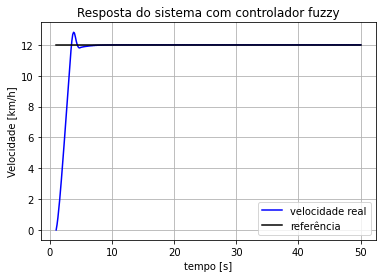

In [8]:
#Plot do resultados
plt.figure(1)
plt.plot(t,0.25*w*3.6, 'b', label='velocidade real')
plt.plot(t,0.25*sp*3.6, 'k', label='referência')
#plt.plot(t, u, 'r', label='tensão')
#plt.plot(t, I1, 'oc', label='corrente')
plt.legend(loc='best')
plt.title('Resposta do sistema com controlador fuzzy')
plt.xlabel('tempo [s]')
plt.ylabel('Velocidade [km/h]')
plt.grid()
plt.show()
#plt.savefig('Resposta_com_controlador_fuzzy_trajeto3.png')


In [9]:
metricasFuzzy = metricasTempoControle(w,t,e,sp)

O valor do overshoot é de  6.844562938334793 %
O valor do tempo de subida é  1.9656160458452723 s
O valor do tempo de pico é  3.808022922636103 s
O valor do tempo de acomodação é  7.739255014326647 s
O valor do erro de regime é  0.0 %


Consumo de carga da bateria<br>
Como Q = integral(i.dt)<br>
Q = carga<br>
i = corrente

In [10]:
q = scipy.integrate.trapz(I1,t) # com freio regenerativo
d = scipy.integrate.trapz(0.25*w*3.6,t) #Distância percorrida no trajeto
#Outra forma de calcular q=> sem freio regenerativo
q1 = 0
dt = t[1]-t[0]
for j in range(len(t)):
    if I1[j] > 0:
        q1 += I1[j]*dt
        
qbat = 18000 # coulombs lembrando que 1 Ah = 3600 C

# Se a bateria possuir eficiência de 90 %
nbat = 0.9
qbatn = qbat*nbat
qrestante = qbat - q1
print('O valor consumido de carga no trajeto foi de: ', q1, 'C')
print('O valor consumido da bateria no trajeto foi de: ', round(q1/qbatn*100,2), '%')
print('O valor restante da bateria no trajeto foi de: ', round((qbatn - q1)/qbatn*100,2), '%')
print('A distância percorrida no trajeto foi de: ', round(d,1), 'm')
print('O valor estimado da autonomia da bateria é de : ', round((d/(q1/qbatn))/1000,2), 'km', ' ou ', round((t[-1]/(q1/qbatn))/60), 'min')


O valor consumido de carga no trajeto foi de:  383.26897773213227 C
O valor consumido da bateria no trajeto foi de:  2.37 %
O valor restante da bateria no trajeto foi de:  97.63 %
A distância percorrida no trajeto foi de:  572.3 m
O valor estimado da autonomia da bateria é de :  24.19 km  ou  35.0 min


##### Gerando o espaço de controle

In [11]:
x = np.arange(-1,1,0.02)
y = np.arange(-1,1,0.02)
xx, yy = np.meshgrid(x,y)
z = np.zeros((len(x),len(y)))

for i in range(len(x)):
    for j in range(len(y)):
        z[i, j] = fuzzyControl(i,j)

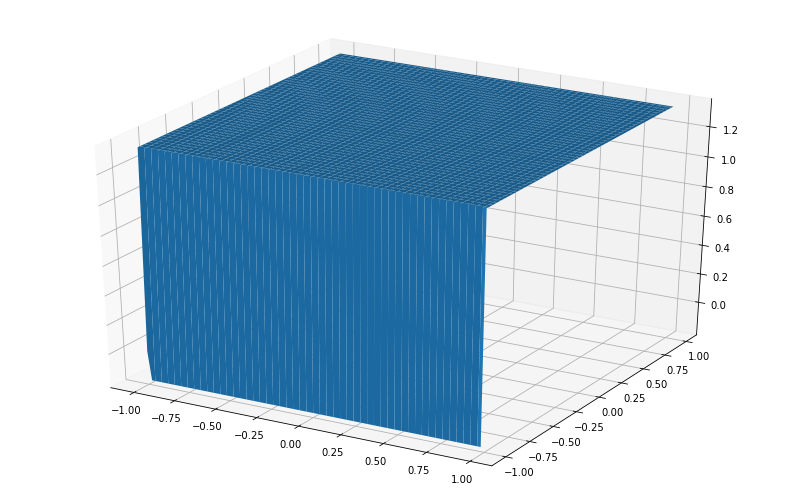

In [13]:
# Criando a figura
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Criando o gráfico
ax.plot_surface(xx, yy, z)
 
# Plot do gráfico
plt.show()

## Sistema de controle PID

##### Definindo as condições iniciais

In [22]:
#Tempo
t = np.linspace(1,50,350)

#trajeto
g = np.linspace(0,8,350)#np.linspace(0,8,350)#np.linspace(3,8,350)#np.ones(350)*2
#tr = np.concatenate((np.ones(50)*np.radians(1),np.ones(50)*np.radians(-2),np.linspace(0,8,250)), axis=0)
#tr = trajeto(g)

#Condições inicias do sistema
w2 = np.zeros(len(t)) #velocidade angular inicial [rad/s]
I2 = np.zeros(len(t)) #corrente na armadura inicial [A]
x0 = [0.0,0.0] #Vetor com as condições iniciais para velocidade angular e corrente
tr = trajeto(g) #inclinação [rad]
u = np.ones(len(t))*0 #Tensão inicial[V]

#Para o controlador PID com La = 2e-3
Kc = 0.27515#0.099#1.65 #Para a constante proporcional
tauI = 0.125#0.07#0.5 #Para a constante integrativa
tauD = 0.0225#0.03#0.08 #Para a constante derivativa

#Armazenando resultados
sc = np.zeros(len(t))  # saída do controlador
vp = np.zeros(len(t))  # variável do processo
epid = np.zeros(len(t))   # erro
ei = np.zeros(len(t))  # erro integral
dvp = np.zeros(len(t)) # derivada de vp

#Para o controle PID
P = np.zeros(len(t))   # proporcional
I = np.zeros(len(t))   # integral
D = np.zeros(len(t))   # derivativo

#Referência
sp = np.zeros(len(t))  # set point
vr1 = 12 # velocidade de refêrencia em km/h
vr2 = 12
vr3 = 12
#wr = (vr1/3.6)/0.25
#sp = np.linspace(0,wr,len(t))
#Vetor referência em velocidade angular - rad/s 
sp[0:80] = (vr1/3.6)/0.25 
sp[80:150] = (vr2/3.6)/0.25
sp[150:] = (vr3/3.6)/0.25

#Limites do controlador -> Caso de saturação
sc_up = 44 #tensão máxima de entrada
sc_down = 0 #Tensão mínima de entrada-> Desligado| Caso seja usado freio regenerativo sc_down será negativo

#Valor atual de vp - será w (velocidade angular)
vp[0] = w2[0]

###### Simulação PID

O sistema de controle PID é representado pelo seguinte diagrama de blocos:

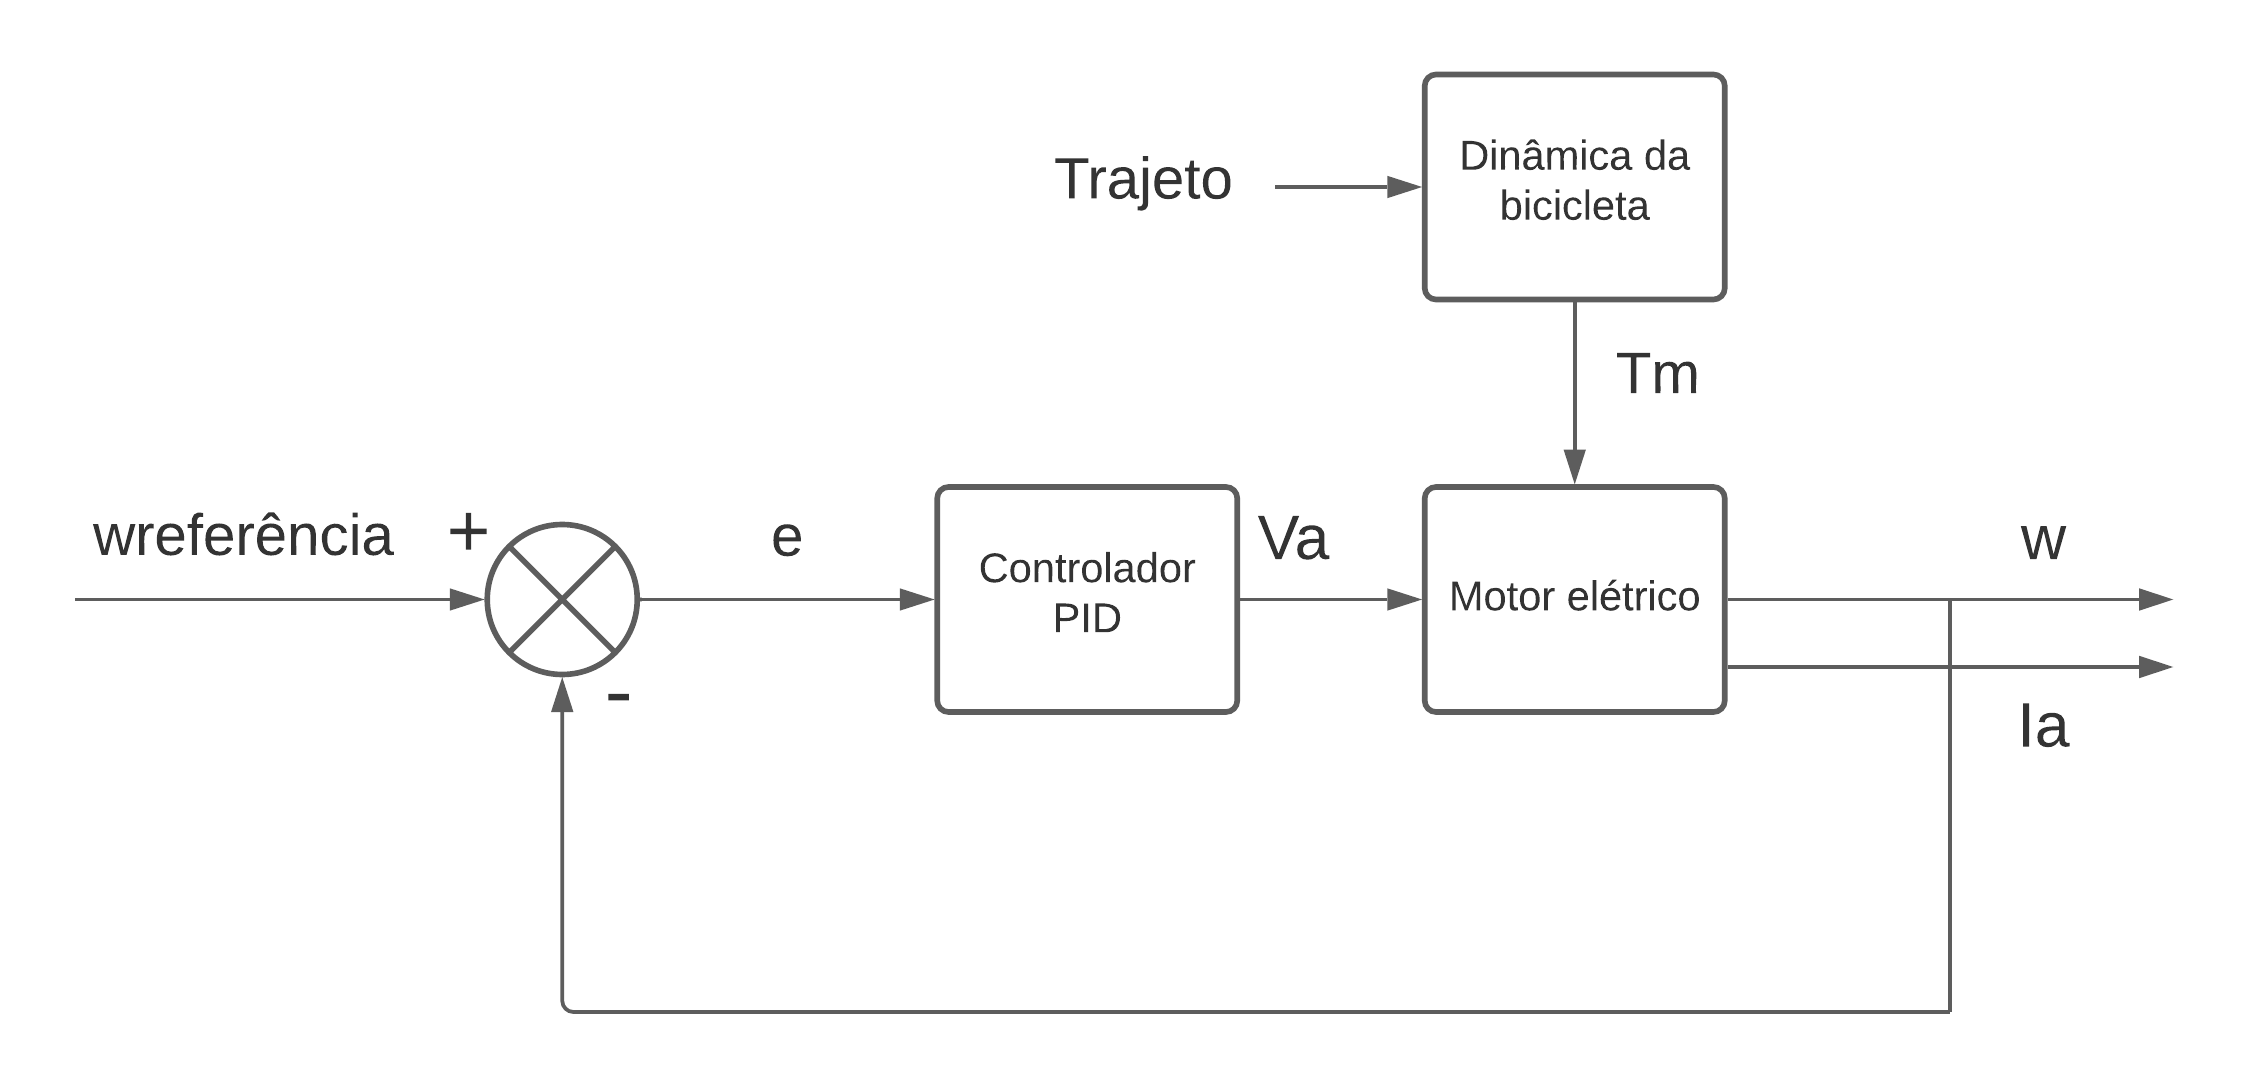

Figura 3 - Diagrama de blocos do sistema de controle fuzzy

In [23]:
for i in range(len(t)-1):
    
    delta_t = t[i+1]-t[i]#passo de tempo
    epid[i] = sp[i] - vp[i] #erro 
    
    if i >= 1:  # calculado a partir da iteração 2
        dvp[i] = (vp[i]-vp[i-1])/delta_t #Derivada numérica de vp
        ei[i] = ei[i-1] + epid[i] * delta_t #Integral numérica do erro
        
    #CONTROLADOR PID
    P[i] = Kc * epid[i]
    I[i] = Kc/tauI * ei[i]
    D[i] = - Kc * tauD * dvp[i]
    sc[i] = sc[0] + P[i] + I[i] + D[i] #Saída do controlador PI
    
    #Testa se o sistema está saturado
    if sc[i] > sc_up:  # checa limite superior
        sc[i] = sc_up
        ei[i] = ei[i] - epid[i] * delta_t # "anti-reset windup"
    if sc[i] < sc_down:  # checa limite inferior
        sc[i] = sc_down
        ei[i] = ei[i] - epid[i] * delta_t # "anti-reset windup"
        
    ts = [t[i],t[i+1]]#Tempo amostral
    
    u[i+1] = sc[i] #Entrada inicial corrigida pelo controlador
    
    y = odeint(bicicleta_eletrica, x0, ts,args=(u[i+1],tr[i])) #Resolução da EDO usando o método integrativo ODEINT de scipy
    
    w2[i+1] = y[-1,0] #vetor com a saída w ao longo do tempo
    I2[i+1] = y[-1,1] #vetor com a saída Ia ao longo do tempo
    vp[i+1] = w2[i+1] #vetor com w para calcular o erro
    x0[0] = w2[i+1] #atualização do valor inicial para velocidade angular
    x0[1] = I2[i+1] #atualização do valor inicial para corrente

##### Visualização dos resultados

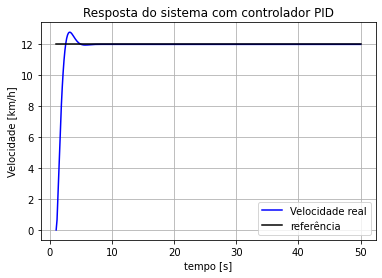

In [24]:
#Plot do resultados
plt.figure(2)
plt.plot(t,0.25*w2*3.6, 'b', label='Velocidade real')
plt.plot(t,0.25*sp*3.6, 'k', label='referência')
#plt.plot(t, u, 'r', label='tensão')
#plt.plot(t, I, 'oc', label='corrente')
plt.title('Resposta do sistema com controlador PID')
plt.xlabel('tempo [s]')
plt.ylabel('Velocidade [km/h]')
plt.legend(loc='best')
plt.grid()
plt.show()
#plt.savefig('Resposta_com_controlador_pid3.png')

In [25]:
metricasPID = metricasTempoControle(w2,t,epid,sp)

O valor do overshoot é de  6.229817096138071 %
O valor do tempo de subida é  1.1232091690544412 s
O valor do tempo de pico é  3.2464183381088825 s
O valor do tempo de acomodação é  7.318051575931232 s
O valor do erro de regime é  0.0 %


In [26]:
q2 = scipy.integrate.trapz(I2,t) # Se for usar freio regenerativo
d = scipy.integrate.trapz(0.25*w2*3.6,t)
#Outra forma de calcular q=> sem freio regenerativo
q3 = 0
dt = t[1]-t[0]
for j in range(len(t)):
    if I2[j] > 0:
        q3 += I2[j]*dt
qbat = 18000 # coulombs lembrando que 1 Ah = 3600 C | para uma bateria com carga de 5000mAh
# Se a bateria possuir eficiência de 90 %
nbat = 0.9
qbatn = qbat*nbat
qrestante = qbat - q2
print('O valor consumido de carga no trajeto foi de: ', q3, 'C')
print('O valor consumido da bateria no trajeto foi de: ', round(q3/qbatn*100,2), '%')
print('O valor restante da bateria no trajeto foi de: ', round((qbatn - q3)/qbatn*100,2), '%')
print('A distância percorrida no trajeto foi de: ', round(d,1), 'm')
print('O valor estimado da autonomia da bateria é de : ', round((d/(q3/qbatn))/1000,2), 'km', ' ou ', round((t[-1]/(q3/qbatn))/60), 'min')

O valor consumido de carga no trajeto foi de:  386.981172982933 C
O valor consumido da bateria no trajeto foi de:  2.39 %
O valor restante da bateria no trajeto foi de:  97.61 %
A distância percorrida no trajeto foi de:  579.3 m
O valor estimado da autonomia da bateria é de :  24.25 km  ou  35.0 min


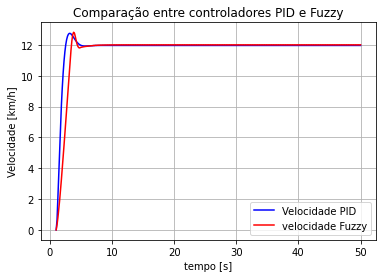

In [27]:
#Plot do resultados
plt.figure(3)
plt.plot(t,0.25*w2*3.6, 'b', label='Velocidade PID')
plt.plot(t,0.25*w*3.6, 'r', label='velocidade Fuzzy')
#plt.plot(t, u, 'r', label='tensão')
#plt.plot(t, I, 'oc', label='corrente')
plt.title('Comparação entre controladores PID e Fuzzy')
plt.xlabel('tempo [s]')
plt.ylabel('Velocidade [km/h]')
plt.legend(loc='best')
plt.grid()
plt.show()
#plt.savefig('Resposta_com_controlador_trajeto2.png')

## Modelo linearizado e análise no domínio da frequência

Para realizar a linearização do sistema a força de atrito com o ar Fw foi linearizada usando-se o método dos mínimos quadrados para encontrar a melhor reta que representa a força de atrito para velocidade de até 20 km/h

##### Linearização de Fw

In [ ]:
def fw(v):
    As = 0.509#Area frontal do ciclista [m²]
    Cw = 0.76#Coeficiente de arrasto do ar
    rho = 1.2#densidade do ar [kg/m³]
    
    return 0.5*As*Cw*rho*v**2

v = np.linspace(0,20,50)
f = fw(v)
A = np.vstack([v,np.ones(len(v))]).T

a, b = np.linalg.lstsq(A,f, rcond =None)[0]

#vizualização
plt.plot(v, f, 'o', label='Força original', markersize=2)
plt.plot(v, a*v + b, 'r', label='Força linearizada')
plt.legend()
plt.show()

#Simplificando para usar a média
fwmedio = np.average(f) 


##### Torque de entrada no sistema

In [ ]:
M = 107
g = 9.81
r = 0.25
#Para trajeto de 3° inclinação constante
tr = np.radians(3)

Th2 = 12 # Torque humano [N.m]

# Força de atrito de rolamento [N]
Crr = 0.0025 #Coeficiente de atrito de rolagem 
frr2 = Crr*M*g*np.cos(tr)

# Força gravitacional [N]
fa2 = M*g*np.sin(tr) 

Tf = 1.71
#Torque de entrada no motor [N.m]
Tm = r*(fwmedio + frr2 + fa2) - Th2 + Tf
print('O torque de entrada adotado será de ', round(Tm,0), 'N.m')

##### Sistema no domínio de Laplace

In [ ]:
#Sistema em laplace
kt = 1.49
ra = 0.1733 #resistência da armadura do motor[ohms]
La = 2e-3 # indutancia da armadura do motor [H] - ou colocar 0.3, calculado deu 3
jl = 0.0625 #inercia da carga - roda da bicicleta roda de 1kg com raio de 0,25m
jm = 7.35e-3 #inercia do motor 
jt = jl+jm #inercia total
B = 1e-3#coeficiente de atrito viscoso no motor

#Parte referente a velocidade angular e a tensão
ui = 36#*fuzzyControl([60, 6, np.radians(3), 30]) #tensão de entrada-usar a função do fuzzy aki [V]
Tt = 11 
s = ctl.TransferFunction([1,0], [1]) #Variável de Laplace
s2 = ctl.TransferFunction([1,0,0],[1]) #Variável de Laplace ao quadrado

#Construindo a função transfêrencia para o motor elétrico
km = kt/(ra*B + kt*kt)
alpha = (La*jt)/(ra*B + kt*kt) 
beta = (ra*jt+La*B)/(ra*B + kt*kt)

G1 = km/(alpha*s2 + beta*s + 1)
G2 = ((-ra/kt)*km*((La/ra)*s+1))/(alpha*s2 + beta*s + 1)


W = G1*ui + G2*Tt

##### Criando o sistema com feedback

In [ ]:
MF = ctl.feedback(W, kt,-1) # malha fechada
#print(MF)

t = np.linspace(0, 20, 1001)

#Talvez fazer um loop aqui, definindo sempre o novo valor da constante usando o fuzzy
tout, yout1 = ctl.step_response(MF, t, X0=0)

plt.figure(4)
plt.plot(tout, yout1, 'b', linewidth=1.5, label='sem controle')
plt.legend(loc='best', shadow=True, framealpha=1)
plt.grid(alpha=0.3)
plt.xlabel('t')
plt.show()

##### Controlador PID

In [ ]:
#Lugar das raízes para encontrar valor do ganho crítico
ctl.rlocus(W)
plt.show()

Para um ganho crítico de Kc = 0,5532 e amortecimento = 1,8e-4 / Valores dados pelo rootLocus - ao omitir "notebook" da opção % matplotlib a função "clicar" fica disponível nos gráficos abertos em pop-ups, e não mais na página notebook. Temos a seguinte resposta ao degrau:

In [ ]:
#Adotando kc = 0.5503
kc = 0.5503
MF = ctl.feedback(kc*W, 1) # malha fechada
print(MF)

t = np.linspace(0, 20, 1001)

plt.figure(5)
tout, yout1 = ctl.step_response(MF, t, X0=0)
plt.plot(tout, yout1, 'b', linewidth=1.5, label='k = kc')
plt.legend(loc='best', shadow=True, framealpha=1)
plt.grid(alpha=0.3)
plt.xlabel('t')
plt.show()

O valor de Tcrítico será o período de oscilação: Tc ~~ 0.04 s/ Obtido no gráfico

In [ ]:
#Construindo o controlador PID usando a regra de Ziegler alterada
tc = 0.04
Kp = 0.5*kc #Proporcional
Ti = 0.005*(1/tc) #Integral
Td = 0.0009*(1/tc) #Derivativo
Cpid = Kp*(1 + 1/(Ti*s) +Td*s)#(0.075*kc*tc*(s+4/tc)*(s+4/tc))/s 1/(Ti*s)
print(Cpid)
print('Kp',Kp)
print('Ti',Ti)
print('Td',Td)

##### Controle PID

In [ ]:
L = Cpid*W #malha aberta
MF2 = ctl.feedback(L, 1) #malha fechada
print(MF2)

plt.figure(6)
tout, yout1 = ctl.step_response(MF2, t, X0=0)
plt.plot(tout, yout1, 'b', linewidth=1.5, label='com controle pid')
plt.legend(loc='best', shadow=True, framealpha=1)
plt.grid(alpha=0.3)
plt.xlabel('t')
plt.show()

In [ ]:
ctl.sisotool(L)

plt.figure(7)  # Diagramas de bode
omega = np.linspace(0.1, 100, 1001)
mag, phase, omega = ctl.bode_plot(L, omega=omega, dB=True)

In [ ]:
a = ctl.stability_margins(L)

In [ ]:
#Tentando usar o sistema fuzzy
t = np.linspace(0.1,20,150)

#Condições inicias do sistema 
w = np.zeros(len(t)) #velocidade angular inicial [rad/s]
I1 = np.zeros(len(t)) #corrente na armadura inicial [A]
x0 = [0.0,0.0] #Vetor com as condições iniciais para velocidade angular e corrente
tr = trajeto(g) #[rad]
u = np.ones(len(t))*36 #Tensão inicial [V]

#Armazenando resultados
sc = np.zeros(len(t))  # saída do controlador
vp = np.zeros(len(t))  # variável do processo
e = np.zeros(len(t))   # erro
ei = np.zeros(len(t))  # erro integral
dvp = np.zeros(len(t)) # derivada de vp

#Referência
sp = np.zeros(len(t))  # set point
vr1 = 1 # velocidade de refêrencia em km/h
vr2 = 1
vr3 = 1

#Vetor referência em velocidade angular - rad/s 
sp[0:50] = (vr1/3.6)/0.25 
sp[50:100] = (vr2/3.6)/0.25
sp[100:] = (vr3/3.6)/0.25

#Limites do controlador -> Caso de saturação
sc_up = 44 #tensão máxima de entrada
sc_down = 0 #Tensão mínima de entrada-> Desligado| Caso seja usado freio regenerativo sc_down será negativo

#Valor atual de vp - será w (velocidade angular)
vp[0] = w[0]

#Simulação
for i in range(len(t)-1):
        
    delta_t = t[i+1]-t[i]#passo de tempo
    e[i] = (sp[i] - vp[i])/sp[i] #erro relativo
    
    #CONTROLADOR FUZZY
    ac = (w[i+1] - w[i])/delta_t #aceleração
    sc[i] = u[i]*fuzzyControl(e[i],ac)#Atualização do valor da tensão pelo "ganho" do controlador fuzzy
    
    #Testa se o sistema está saturado
    if sc[i] > sc_up:  # checa limite superior
        sc[i] = sc_up
        
    if sc[i] < sc_down:  # checa limite inferior
        sc[i] = sc_down
        
        
    ts = [t[i],t[i+1]]#Tempo amostral
    
    u[i+1] = sc[i] #Entrada inicial corrigida pelo controlador
    
    y = G1*u[i+1] + G2*Tt #Criando o sistema
    MF3 = ctl.feedback(y, 1)
    tout, y = ctl.step_response(MF3, ts, X0=0)
    
    w[i+1] = y[-1] #vetor com a saída w ao longo do tempo
    #I1[i+1] = y[-1,1] #vetor com a saída Ia ao longo do tempo
    vp[i+1] = w[i+1] #vetor com w para calcular o erro
    x0[0] = w[i+1] #atualização do valor inicial para velocidade angular
    #x0[1] = I1[i+1] #atualização do valor inicial para corrente

In [ ]:
#Plotando resultado
#Plot do resultados
plt.figure(9)
plt.plot(t,0.25*w*3.6, 'b', label='velocidade real')
plt.plot(t,0.25*sp*3.6, 'r', label='referência')
#plt.plot(t, u, 'r', label='tensão')
#plt.plot(t, I1, 'oc', label='corrente')
plt.legend(loc='best')
plt.title('Resposta do sistema com controlador fuzzy')
plt.xlabel('tempo [s]')
plt.ylabel('Velocidade [km/h]')
plt.grid()
plt.show()